In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json


Load the Dataset and clean it while only extracting the song features: tempo, energy, loudness and valence. 

In [4]:
file_path = '../Spotify_Song_Attributes.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Select the columns you want
song_attributes = ['id', 'tempo', 'energy', 'loudness', 'valence']
df_filtered = df[song_attributes]

# Drop rows with missing values
df_filtered = df_filtered.dropna(subset=['tempo', 'energy', 'loudness', 'valence'])

# Display the filtered DataFrame
df_filtered.head()


,id,tempo,energy,loudness,valence
0,7dTxqsaFGHOXwtzHINjfHv,162.139,0.799,-4.939,0.577
1,14Qcrx6Dfjvcj0H8oV8oUW,112.241,0.130,-17.719,0.122
2,7K9Z3yFNNLv5kwTjQYGjnu,132.012,0.814,-3.788,0.509
3,3koAwrM1RO0TGMeQJ3qt9J,120.969,0.596,-9.804,0.896
4,4ByEFOBuLXpCqvO1kw8Wdm,124.945,0.726,-11.402,0.507


Standardize the song attributes, appling KMeans clustering to categorize songs into three intensity clusters: low, mid, high intensity. 

Visualize the clusters on a scatter plot.

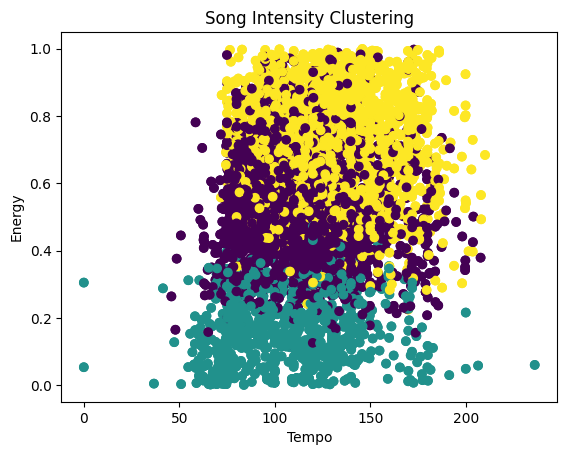

                       id    tempo  energy  loudness  valence  intensity
0  7dTxqsaFGHOXwtzHINjfHv  162.139   0.799    -4.939    0.577          2
1  14Qcrx6Dfjvcj0H8oV8oUW  112.241   0.130   -17.719    0.122          1
2  7K9Z3yFNNLv5kwTjQYGjnu  132.012   0.814    -3.788    0.509          2
3  3koAwrM1RO0TGMeQJ3qt9J  120.969   0.596    -9.804    0.896          2
4  4ByEFOBuLXpCqvO1kw8Wdm  124.945   0.726   -11.402    0.507          2


In [5]:
# prepare data for clustering (use features only)
X = df_filtered[['tempo', 'energy', 'loudness', 'valence']]

# standardize the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply KMeans clustering (use 3 clusters for low, mid, high intensity)
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtered['intensity'] = kmeans.fit_predict(X_scaled)

# visualize the clusters 
plt.scatter(df_filtered['tempo'], df_filtered['energy'], c=df_filtered['intensity'], cmap='viridis')
plt.xlabel('Tempo')
plt.ylabel('Energy')
plt.title('Song Intensity Clustering')
plt.show()

print(df_filtered.head())

Remove the 'intensity' and 'id' columns. 

Standardize the remaining features, and then split the dataset into training and test sets with 80% for training and 20% for testing.

In [6]:
X = df_filtered.drop(['intensity', 'id'], axis=1).values
y = df_filtered['intensity'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)



Build a neural network with one hidden layer that uses ReLU activation for the hidden layer and softmax for the output layer. 

Initialize the weights with He initialization, compute forward and backward passes, and update the weights using gradient descent. 

After training, evaluate the model's accuracy on the test data and output the classification.

In [25]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # initialize weights and biases with He initialization for ReLU activation
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2. / self.input_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2. / self.hidden_size)
        self.b2 = np.zeros((1, self.output_size))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2
        
    def backward(self, X, y, output, learning_rate):
        # compute loss (cross-entropy)
        error = output - y
        d_W2 = np.dot(self.a1.T, error)
        d_b2 = np.sum(error, axis=0, keepdims=True)
        
        d_a1 = np.dot(error, self.W2.T)
        d_z1 = d_a1 * self.relu_derivative(self.a1)
        d_W1 = np.dot(X.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)
        
        # update weights and biases
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
    
    def train(self, X, y, learning_rate, epochs):
        # one-hot encode the labels y
        y_one_hot = np.eye(self.output_size)[y]
        
        for epoch in range(epochs):
            # forward pass
            output = self.forward(X)
            
            # compute loss (cross-entropy)
            loss = -np.mean(np.sum(y_one_hot * np.log(output + 1e-10), axis=1))  # Cross-entropy loss
            print(f"Epoch {epoch}/{epochs}, Loss: {loss}")
            
            # backward pass
            self.backward(X, y_one_hot, output, learning_rate)
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)
    
    def save_model(self, file_path):
        # save the model weights and biases to a json file
        data = {
            "W1": self.W1.tolist(),
            "b1": self.b1.tolist(),
            "W2": self.W2.tolist(),
            "b2": self.b2.tolist()
        }
        with open(file_path, 'w') as f:
            json.dump(data, f)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        # load the model weights and biases from a json file
        with open(file_path, 'r') as f:
            data = json.load(f)
            self.W1 = np.array(data["W1"])
            self.b1 = np.array(data["b1"])
            self.W2 = np.array(data["W2"])
            self.b2 = np.array(data["b2"])
        print(f"Model loaded from {file_path}")

learning_rate = 0.0001 
epochs = 1000
nn = NeuralNetwork(input_size=X_train.shape[1], hidden_size=64, output_size=len(np.unique(y_train)))
nn.train(X_train, y_train, learning_rate, epochs)

# evaluate on test data
predictions = nn.predict(X_test)
accuracy = np.mean(predictions == y_test) * 100  
print(f"Accuracy on test data: {accuracy:.2f}%")

Epoch 0/1000, Loss: 1.9209352001603097
Epoch 1/1000, Loss: 1.2906458501539786
Epoch 2/1000, Loss: 0.3145302886592575
Epoch 3/1000, Loss: 0.2182272960381708
Epoch 4/1000, Loss: 0.18552783466366143
Epoch 5/1000, Loss: 0.1722657837169426
Epoch 6/1000, Loss: 0.1657681677559198
Epoch 7/1000, Loss: 0.16134677944601136
Epoch 8/1000, Loss: 0.15764981121873245
Epoch 9/1000, Loss: 0.15431670724855198
Epoch 10/1000, Loss: 0.151237170384581
Epoch 11/1000, Loss: 0.1483591004887174
Epoch 12/1000, Loss: 0.14565448156765495
Epoch 13/1000, Loss: 0.14310621395858586
Epoch 14/1000, Loss: 0.14069986753566366
Epoch 15/1000, Loss: 0.13841276364864177
Epoch 16/1000, Loss: 0.13623490734170618
Epoch 17/1000, Loss: 0.1341518977168682
Epoch 18/1000, Loss: 0.13216573943196105
Epoch 19/1000, Loss: 0.13026890107666925
Epoch 20/1000, Loss: 0.12844877021150197
Epoch 21/1000, Loss: 0.12670210468880558
Epoch 22/1000, Loss: 0.12502800555257418
Epoch 23/1000, Loss: 0.12342207810357833
Epoch 24/1000, Loss: 0.1218734278848

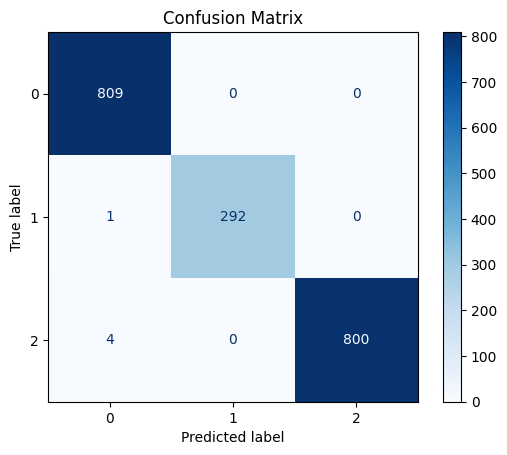

In [8]:
y_pred = nn.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Below shows an example of how to use the neural network to classify a demo song given its tempo, energy, loudness, and valence.

In [ ]:
# links intensity (which we obtained from kmeans clustering) to heart rates
heart_rate_ranges = {
    0: "50-90 bpm (Low Intensity)",
    1: "91-130 bpm (Medium Intensity)",
    2: "131-180 bpm (High Intensity)"
}

# can read a random song from the data if we want
demo_song_features = [60, 0.8, -5, 0.9] # [tempo (BPM), energy [0.0-1.0], loudness (dB), valence [0.0-1.0]]

demo_song = np.array(demo_song_features).reshape(1, -1)
demo_song_scaled = scaler.transform(demo_song)
predicted_class = nn.predict(demo_song_scaled)
print(predicted_class)
print(f"The song is classified as: {heart_rate_ranges[predicted_class[0]]}")

[[60.   0.8 -5.   0.9]]
[2]
The song is classified as: 131-180 bpm (High Intensity)
